
## Introduction:

1. The integration of SciBERT Embeddings with a Convolutional Neural Network (CNN) and BERT topic modeling to extract the top 12 most important words yielded the most favorable results.

2. This combination emerged as the superior approach in our quest to boost the performance of text classification tasks.

3. The SciBERT-CNN with BERT topic modeling approach significantly outperformed other models, cementing its position as our architecture of choice for the detailed task at hand.


## Step 1: Install the necessary dependencies

In [ ]:
!pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 85.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 23.9 MB/s eta 0:00:00
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 8.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (7

In [ ]:
!pip install -q transformers==4.37.2

In [ ]:
!pip install pydot

## Step 2: Import the necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import seaborn as sns
from wordcloud import WordCloud

import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
nltk.download('stopwords')
nltk.download('punkt')

import ast
from google.colab import drive
drive.mount('/content/drive')

from transformers import AutoTokenizer, TFAutoModel, TFAutoModelForMaskedLM
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Step 3:  Load and Inspect the data

To save time and compute resources, we first downloaded the data from Hugging Face and then saved it as a CSV file, which we subsequently loaded from Google Drive.

In [ ]:
file_path = '/content/drive/MyDrive/keybert/'
train_df = pd.read_csv(file_path + 'train_df_important.csv')
val_df = pd.read_csv(file_path + 'val_df_important.csv')
test_df = pd.read_csv(file_path + 'test_df_important.csv')

In [ ]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(32072, 8)
(4009, 8)
(4008, 8)


In [ ]:
train_df.head(1)

,title,abstract,subjareas,keywords,asjc,body_text,author_highlights,important_words
0,PEITC induces apoptosis of Human Brain Gliobla...,Glioblastoma is the most common and most aggre...,"['BIOC', 'NEUR']","['Apoptosis', 'Caspases', 'Glioblastoma', 'Mit...","['1307', '2804']",['Glioblastoma is the most common and most agg...,['We investigate the pro-apoptotic effects of ...,"[('glioblastoma', 0.7298), ('radiotherapy', 0...."


In [ ]:
val_df.head(1)

,title,abstract,subjareas,keywords,asjc,body_text,author_highlights,important_words
0,"Chemical profile, cytotoxic and antiparasitic ...",The aim of this study was carry out a phytoche...,['AGRI'],"['Antiepimastigote', 'Antipromastigote activit...",['1110'],['Infectious and parasitic diseases are still ...,['The fingerprint of phytocompounds identified...,"[('epidemiological', 0.5405), ('trypanosomiasi..."


In [ ]:
test_df.head(1)

,title,abstract,subjareas,keywords,asjc,body_text,author_highlights,important_words
0,Structure and content of phenolics in eggplant...,In the last years eggplant has received a grea...,['AGRI'],"['Anthocyanins', 'Chlorogenic acid', 'Delphini...",['1110'],"['Eggplant (also known as brinjal, aubergine, ...","['Eggplant is considered a functional food, be...","[('eggplant', 0.7497), ('eggplant', 0.6502), (..."


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32072 entries, 0 to 32071
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   title              32072 non-null  object
 1   abstract           31836 non-null  object
 2   subjareas          32072 non-null  object
 3   keywords           32072 non-null  object
 4   asjc               32072 non-null  object
 5   body_text          32072 non-null  object
 6   author_highlights  32072 non-null  object
 7   important_words    32072 non-null  object
dtypes: object(8)
memory usage: 2.0+ MB


The below function safely evaluates and convert string representations of Python literals in specified dataFrame columns to their actual Python objects. It checks and reports on any entries that fail to convert. The process is applied to multiple columns across training, validation, and test DataFrames to ensure data consistency and readiness for further analysis.

In [ ]:
def safe_literal_eval(s):
  """
  The below function safely evaluates and convert string representations of Python literals in specified dataFrame columns to their actual Python objects.
  It checks and reports on any entries that fail to convert. The process is applied to multiple columns across training, validation, and test DataFrames to ensure data
  consistency and readiness for further analysis.

  """

    try:
        return ast.literal_eval(s)
    except ValueError:
        return s

def apply_safe_literal_eval_and_check(df, column_name):
    df[column_name] = df[column_name].apply(safe_literal_eval)
    not_converted = df[column_name].apply(lambda x: isinstance(x, str))
    if not_converted.any():
        print(f"Rows that were not converted in column '{column_name}':")
        print(df.loc[not_converted, column_name].head())

columns_to_convert = ['important_words', 'subjareas', 'author_highlights', 'asjc', 'body_text', 'keywords']

for column in columns_to_convert:
    apply_safe_literal_eval_and_check(train_df, column)
    apply_safe_literal_eval_and_check(val_df, column)
    apply_safe_literal_eval_and_check(test_df, column)

## Step 3: Visualize the distribution of classes and verify the data format of the columns

In [ ]:
label_counts = pd.Series([label for sublist in train_df['subjareas'] for label in sublist]).value_counts()
label_counts_df = label_counts.reset_index()
label_counts_df.columns = ['Subject Area', 'Frequency']

fig = px.bar(label_counts_df, x='Subject Area', y='Frequency', title='Frequency of Each Subject Area Label')
fig.show()


In [ ]:
train_df.head()

,title,abstract,subjareas,keywords,asjc,body_text,author_highlights,important_words
0,PEITC induces apoptosis of Human Brain Gliobla...,Glioblastoma is the most common and most aggre...,"[BIOC, NEUR]","[Apoptosis, Caspases, Glioblastoma, Mitochondr...","[1307, 2804]",[Glioblastoma is the most common and most aggr...,[We investigate the pro-apoptotic effects of P...,"[(glioblastoma, 0.7298), (radiotherapy, 0.4073..."
1,Multi-step biocatalytic strategies for chiral ...,Chiral amino alcohols are structural motifs pr...,"[BIOC, CENG, IMMU]","[Cascades, Chiral amino alcohols, Recycling sy...","[1303, 1305, 1502, 2402]",[Chiral amino alcohols are key functionalities...,[A double-recycling cascade for the synthesis ...,"[(sphingolipids, 0.5694), (biocatalytic, 0.665..."
2,Achieving respectable motherhood? Exploring th...,This paper explores the tension between post-f...,[SOCI],[],"[3303, 3304, 3312]","[As Jackson, Paechter, and Renold (2010) maint...",[Focus on women's agency in maternal choice-ma...,"[(discourse, 0.4245), (women, 0.4883), (femini..."
3,"Soft++, a multi-parametric non-saturating non-...",A key strategy to enable training of deep neur...,"[COMP, NEUR]","[Activation function, Convolutional neural net...","[1702, 1706, 2805]",[Deep learning has become extremely popular in...,[],"[(popular, 0.358), (neural, 0.443), (gpus, 0.4..."
4,Imaging ancient and mummified specimens: Dual-...,"In mummified animals and humans, soft tissues ...",[SOCI],"[Ancient Egypt, Animal mummies, Computed tomog...","[1204, 3302]","[A challenge in the field of paleoradiology, w...",[Soft tissues and bone can have similar densit...,"[(paleoradiology, 0.5741), (mummification, 0.5..."


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32072 entries, 0 to 32071
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   title              32072 non-null  object
 1   abstract           31836 non-null  object
 2   subjareas          32072 non-null  object
 3   keywords           32072 non-null  object
 4   asjc               32072 non-null  object
 5   body_text          32072 non-null  object
 6   author_highlights  32072 non-null  object
 7   important_words    32072 non-null  object
dtypes: object(8)
memory usage: 2.0+ MB


## Step 4: Perform BERT topic modeling to extract the top most important 50 words from body_text column

In [ ]:
count_vectorizer = CountVectorizer(max_features=8000, stop_words='english')

bertopic_model = BERTopic(embedding_model="all-MiniLM-L6-v2", vectorizer_model=count_vectorizer, top_n_words=50)

def createBERTopic(df):
    """
    Applies topic modeling to the 'body_text' column of a DataFrame using the BERTopic model.

    Args:
      df (DataFrame): The DataFrame containing the text data in the 'body_text' column. It's expected that each row in this column contains text data.

    Returns:
      tuple: A tuple containing two elements:
        - DataFrame: The input DataFrame updated with two new columns:
            - 'topic': Contains the topic IDs assigned to each row based on the text in 'body_text'.
            - 'BERTopic_words': Lists the most representative words for the corresponding topic of each row.
        - dict: A dictionary where keys are topic IDs and values are lists of words associated with each topic, showing the top words that characterize each topic.

    Description:
    This function first ensures that all entries in the 'body_text' column are strings, filling missing values with an empty string and converting any non-string entries to string.
    It then uses the BERTopic model, which incorporates a pre-trained Sentence Transformer embedding model and a CountVectorizer for text vectorization, to fit the text data and extract topics.
    The function adds a 'topic' column to the DataFrame indicating the topic ID for each entry and a 'BERTopic_words' column listing the representative words for the topic of each entry. The function also returns a dictionary mapping topics to their representative words, useful for further analysis of topics.
    """
    if not all(isinstance(x, str) for x in df['body_text']):
        df['body_text'] = df['body_text'].fillna('').astype(str)

    topics, _ = bertopic_model.fit_transform(df['body_text'])

    df_topics = bertopic_model.get_topic_info()

    df['topic'] = topics

    topic_words = {topic: bertopic_model.get_topic(topic) for topic in topics}

    df['BERTopic_words'] = df['topic'].apply(lambda x: topic_words[x] if x in topic_words else [])

    return df, topic_words

train_df, topic_words = createBERTopic(train_df)
val_df, topic_words = createBERTopic(val_df)
test_df, topic_words = createBERTopic(test_df)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



In [ ]:
train_df['BERTopic_words'].head()

0    [(tumor, 0.01828466668416377), (pes, 0.0099775...
1    [(1h, 0.020368719568948177), (hz, 0.0194618696...
2    [(et, 0.0016958325441984324), (al, 0.001693553...
3    [(learning, 0.015174855650902113), (image, 0.0...
4    [(et, 0.0016958325441984324), (al, 0.001693553...
Name: BERTopic_words, dtype: object

## Step 5: Data Pre-processing

1. Data Segmentation and Preparation: We divide the text data into segments of abstracts, titles, and body texts and prepare them by trimming each to specific word limits to ensure conciseness and relevance. We initially divide each document into an abstract (limited to 200 words), a title (capped at 50 words), and body text (250 words). Additionally, we enrich this segment by identifying and including the top 10 keywords from the body text using BERT-based topic modeling. We then extended the body text to two more segments by adding an additional 500 words each segment to deepen the analysis.

2. Topic Modeling: We used a BERT-based topic modeling technique on the body text to distill topics that encapsulate the corpus's semantic content, aiding in dimensionality reduction and contextual understanding. We then concatenated the abstract, title, and body text and extracted topics as the model's input.

3. Multi-Label Binarization and Tokenization: Subject area labels are encoded using MultiLabelBinarizer to prepare for multi-label classification, converting categorical labels into a binary format suitable for the model to process. The concatenated texts are tokenized using the SciBERT tokenizer, creating the necessary inputs for the model, including input IDs and attention masks.


In [ ]:
def trim_text(text, word_limit):
    if isinstance(text, list):
        text = ' '.join(str(x) for x in text)
    if pd.isna(text):
        return ""
    words = text.split()[:word_limit]
    return ' '.join(words)

def add_additional_body_text(body_text, start_index, word_limit):
    if isinstance(body_text, list):
        body_text = ' '.join(body_text)
    words = body_text.split()[start_index:start_index+word_limit]
    return ' '.join(words)

def trim_topic_words(topic_words, word_limit):
    if isinstance(topic_words, list):
        words = [word for word, _ in topic_words[:word_limit]]
        return ' '.join(words)
    return ""

def process_texts(df, abstract_column_name, body_text_column_name, title_column_name, bertopic_words_column_name, word_limit_for_bertopic_words):
    concatenated_texts = []
    for abstract, body, title, bertopic_words in zip(df[abstract_column_name], df[body_text_column_name], df[title_column_name], df[bertopic_words_column_name]):
        bertopic_words_processed = trim_topic_words(bertopic_words, word_limit_for_bertopic_words)
        initial_sequence = f"{trim_text(abstract, 200)} [SEP] {trim_text(body, 250)} [SEP] {trim_text(title, 50)} [SEP] {bertopic_words_processed}"
        text_segments = [initial_sequence]
        additional_body_text = add_additional_body_text(body, 300, 500)
        if additional_body_text:
            text_segments.append(additional_body_text)
        second_additional_body_text = add_additional_body_text(body, 800, 500)
        if second_additional_body_text:
            text_segments.append(second_additional_body_text)
        concatenated_texts.append(text_segments)
    return concatenated_texts

def prepare_elsevier_data(train_df, val_df, test_df, abstract_column_name='abstract', body_text_column_name='body_text', title_column_name='title', label_column_name='subjareas', bertopic_words_column_name='BERTopic_words', word_limit_for_bertopic_words=10):
    mlb = MultiLabelBinarizer()
    all_labels = pd.concat([train_df[label_column_name], val_df[label_column_name], test_df[label_column_name]])
    mlb.fit(all_labels)

    train_labels = mlb.transform(train_df[label_column_name])
    val_labels = mlb.transform(val_df[label_column_name])
    test_labels = mlb.transform(test_df[label_column_name])

    concatenated_train_texts = process_texts(train_df, abstract_column_name, body_text_column_name, title_column_name, bertopic_words_column_name, word_limit_for_bertopic_words)
    concatenated_val_texts = process_texts(val_df, abstract_column_name, body_text_column_name, title_column_name, bertopic_words_column_name, word_limit_for_bertopic_words)
    concatenated_test_texts = process_texts(test_df, abstract_column_name, body_text_column_name, title_column_name, bertopic_words_column_name, word_limit_for_bertopic_words)

    return (concatenated_train_texts, train_labels, concatenated_val_texts, val_labels, concatenated_test_texts, test_labels, mlb.classes_)

concatenated_train_texts, train_labels, concatenated_val_texts, val_labels, concatenated_test_texts, test_labels, target_names = prepare_elsevier_data(train_df, val_df, test_df)


In [ ]:
print(train_labels[:2])
print(concatenated_train_texts[:2])
print(len(target_names))

[[0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]]
[["Glioblastoma is the most common and most aggressive primary brain malignancy. The multimodality treatments for this tumor including surgery, radiotherapy, and chemotherapy, are still not completely satisfied. Phenethyl isothiocyanate (PEITC), one member of the isothiocyanate family, has been shown to induce apoptosis in many human cancer cells. In this study, we investigate the pro-apoptotic effects caused by PETIC in human brain glioblastoma multiforme GBM 8401 cells. In our data, PEITC induced the cell morphological changes and decreased the cell viability of GBM8401 cells in a dose- and time-dependent manner. Moreover, the analysis of cell cycle distribution detected by flow cytometry showed that PEITC induced significantly sub-G1 phase (apoptotic population) in GBM 8401 cells. In addition, PEITC promoted the production of reactive oxygen species (ROS) and increase in [Ca2+]I, but decreased the mitocho

In [ ]:
print(len(concatenated_train_texts))
print(len(concatenated_val_texts))

32072
4009


In [ ]:
# Convert validation labels to a NumPy array
npvalid_labels = np.asarray(val_labels)
nptrain_labels = np.asarray(train_labels)
nptest_labels = np.asarray(test_labels)


## step 5: Call SciBERT tokenizer from Hugging Face

The code snippet initializes components from the Hugging Face library using the 'allenai/scibert_scivocab_cased' model checkpoint, designed for scientific texts. It sets up a SciBERT tokenizer for processing text, a TensorFlow-based SciBERT model for various NLP tasks, and a masked language model variant of SciBERT to handle tasks involving predicting missing words in text sequences. This setup enables the application of advanced NLP techniques specifically tailored for the scientific domain

In [ ]:
model_checkpoint = 'allenai/scibert_scivocab_cased'

scibert_tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

scibert_model = TFAutoModel.from_pretrained(model_checkpoint, from_pt=True)

scibert_mlm = TFAutoModelForMaskedLM.from_pretrained(model_checkpoint, from_pt=True)

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/222k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint

## Step 6: Tokenize the list of text segments using SciBERT tokenizer and get the encodings of train, validation and test data

In [ ]:
def tokenize_texts(text_segments_list, tokenizer, max_length=512):
    """
    Tokenizes a list of text segments using the provided tokenizer.

    Args:
        text_segments_list (list of list of str): Each inner list contains one or more text segments for a document.
        tokenizer: The tokenizer to use.
        max_length (int): The maximum token length for each segment.

    Returns:
        A list of tokenized and encoded text segments suitable for model input.
    """
    tokenized_outputs = []

    for text_segments in text_segments_list:
        document_encodings = [tokenizer(text, truncation=True, padding='max_length', max_length=max_length, return_tensors='tf') for text in text_segments]
        tokenized_outputs.append(document_encodings)

    return tokenized_outputs

train_encodings = tokenize_texts(concatenated_train_texts, scibert_tokenizer)
valid_encodings = tokenize_texts(concatenated_val_texts, scibert_tokenizer)
test_encodings = tokenize_texts(concatenated_test_texts, scibert_tokenizer)


In [ ]:
train_df.tail()

,title,abstract,subjareas,keywords,asjc,body_text,author_highlights,important_words,topic,BERTopic_words
32067,Pressure drop and heat transfer properties of ...,With the aid of additive manufacturing is now ...,"[CENG, CHEM, ENER, ENGI]","[Additive manufacturing, Aluminum, Foams, Heat...","[1500, 1600, 2102, 2209]",['The utilization of structured catalysts has ...,[Self-contained Aluminium iso-reticular cubic ...,"[(catalysts, 0.6594), (packings, 0.526), (foam...",-1,"[(et, 0.0016958325441984324), (al, 0.001693553..."
32068,Unique classification of parathyroid dysfuncti...,Introduction: Hypoparathyroidism is a rare com...,[MEDI],"[Intact parathyroid hormone (iPTH), Parathyroi...",[2746],['Parathyroid dysfunction notably hypoparathyr...,[Prevalence of parathyroid dysfunction in tran...,"[(hypoparathyroidism, 0.597), (hypoparathyroid...",1,"[(food, 0.015161566143516008), (foods, 0.01067..."
32069,Consumption of a multivitamin/multimineral sup...,Background: The efficacy of multivitamin/multi...,[MEDI],"[Clinical research, Dietary supplements, Multi...","[1106, 2701, 2916]",['National Health and Nutrition Examination Su...,[Multivitamin/mineral (MVM) supplementation in...,"[(rda, 0.5069), (nutrients, 0.5104), (suppleme...",1,"[(food, 0.015161566143516008), (foods, 0.01067..."
32070,Analytical framework and data for evaluating a...,This article contains four data tables: 1 and ...,[MULT],"[Content analysis, Justice, Plan evaluation, R...",[1000],['This Data in Brief submission contains an an...,[],"[(resilience, 0.533), (tables, 0.7635), (rubri...",351,"[(resilience, 0.097378835368085), (indicators,..."
32071,Modes of transport in the Northeast Corridor: ...,These data support the research article: ‘The ...,[MULT],"[Demand, Elasticity, Maximisation, Megaregion,...",[1000],['The data can be found in the attached calcul...,[],"[(elasticities_nec_ier_rev, 0.6412), (transpor...",381,"[(traffic, 0.03472353147196243), (route, 0.022..."


## Step 6: Verify the shape of input ids, token_type_ids and attention mask for the given encodings

In [ ]:
def print_encoding_shapes(encodings_list, encoding_type="Abstract"):
    """
    Prints the shapes of input_ids, token_type_ids, and attention_mask for given encodings.

    Since encodings are now in a list of lists of tensors format, we need to iterate through them.

    Args:
    - encodings_list: A list of lists of tokenized encodings from the BERT tokenizer.
    - encoding_type: A string indicating the type of encoding (e.g., "Abstract" or "Body").
    """
    print(f"\n{encoding_type} Texts Encodings Shapes:")

    for doc_idx, doc_encodings in enumerate(encodings_list):
        print(f"Document {doc_idx + 1}:")
        for seg_idx, seg_encodings in enumerate(doc_encodings):
            input_ids_shape = seg_encodings['input_ids'].shape
            token_type_ids_shape = seg_encodings['token_type_ids'].shape
            attention_mask_shape = seg_encodings['attention_mask'].shape

            print(f" Segment {seg_idx + 1}:")
            print(f"  Input IDs shape: {input_ids_shape}")
            print(f"  Token Type IDs shape: {token_type_ids_shape}")
            print(f"  Attention Mask shape: {attention_mask_shape}")

print_encoding_shapes(train_encodings, "Train")
print_encoding_shapes(valid_encodings, "Validation")
print_encoding_shapes(test_encodings, "Test")

Streaming output truncated to the last 5000 lines.
 Segment 3:
  Input IDs shape: (1, 512)
  Token Type IDs shape: (1, 512)
  Attention Mask shape: (1, 512)
Document 3621:
 Segment 1:
  Input IDs shape: (1, 512)
  Token Type IDs shape: (1, 512)
  Attention Mask shape: (1, 512)
 Segment 2:
  Input IDs shape: (1, 512)
  Token Type IDs shape: (1, 512)
  Attention Mask shape: (1, 512)
Document 3622:
 Segment 1:
  Input IDs shape: (1, 512)
  Token Type IDs shape: (1, 512)
  Attention Mask shape: (1, 512)
 Segment 2:
  Input IDs shape: (1, 512)
  Token Type IDs shape: (1, 512)
  Attention Mask shape: (1, 512)
 Segment 3:
  Input IDs shape: (1, 512)
  Token Type IDs shape: (1, 512)
  Attention Mask shape: (1, 512)
Document 3623:
 Segment 1:
  Input IDs shape: (1, 512)
  Token Type IDs shape: (1, 512)
  Attention Mask shape: (1, 512)
 Segment 2:
  Input IDs shape: (1, 512)
  Token Type IDs shape: (1, 512)
  Attention Mask shape: (1, 512)
 Segment 3:
  Input IDs shape: (1, 512)
  Token Type IDs

step 3: Set maximum dimension length based on the data

## Step 7 : Compute Sample weights

The below function provides a mechanism to enhance model fairness and performance by adjusting for uneven label distribution in training data. It computes the sample weights. It calculates the frequency of each unique label. The, it calculates the inverse of these frequencies to determine preliminary weights and  normalizes these preliminary weights  by dividing each by the sum of all weights. The function returns a numpy array where each element corresponds to the computed weight for a sample in the DataFrame. These weights can be used during the training of a model to adjust the influence of each sample based on its labels, effectively addressing class imbalance by giving more importance to rarer labels.

In [ ]:
import pandas as pd
import numpy as np

def compute_sample_weights(df, label_column):
    """
    Compute sample weights for multi-label classification.

    Parameters:
    - df: pandas DataFrame containing the training data
    - label_column: string name of the DataFrame column containing the labels lists

    Returns:
    - sample_weights: numpy array of sample weights where rows correspond to samples
    """
    label_freq = pd.Series([label for sublist in df[label_column] for label in sublist]).value_counts()

    label_weights = 1 / label_freq

    label_weights /= label_weights.sum()

    label_weight_map = label_weights.to_dict()

    sample_weights = []

    for labels in df[label_column]:
        sample_weight = sum([label_weight_map[label] for label in labels])
        sample_weights.append(sample_weight)

    return np.array(sample_weights)

sample_weights = compute_sample_weights(train_df, 'subjareas')



## Step 8: Use the Hybrid model SciBRT-CNN to train the data for multi label text classification

This model fine-tunes a pretrained SciBERT model for multi-label text classification, enriched with a CNN layer for enhanced feature extraction from concatenated embeddings of three input segments. It employs convolution and max-pooling followed by dense layers, and it outputs predictions for 18 classes using a sigmoid activation function. The model is compiled with the Adam optimizer and binary cross-entropy loss, targeting improved performance through the combined strengths of transformers and CNNs.

Model Spec:
CLS embeddings concatenated from  three  input segments

CNN:

Conv1D:
    CNN filters = 64
    Kernel Size = 5
    Pooling size = 2

Dense Layers = 1024

Dropout = 0.1





In [ ]:
def build_finetune_scibert_with_cnn_segments(pretrained_model_name_or_path='allenai/scibert_scivocab_cased', num_classes=18, hidden_size=[1024], dropout=0.1, learning_rate=0.00005, cnn_filters=64, kernel_size=5, pooling_size=2, from_pt=True):
    tf.keras.backend.clear_session()

    pretrained_LLM = TFAutoModel.from_pretrained(pretrained_model_name_or_path, from_pt=from_pt)
    pretrained_LLM.trainable = True

    input_ids_1 = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_ids_segment_1')
    attention_mask_1 = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='attention_mask_segment_1')

    input_ids_2 = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_ids_segment_2')
    attention_mask_2 = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='attention_mask_segment_2')

    input_ids_3 = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_ids_segment_3')
    attention_mask_3 = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='attention_mask_segment_3')

    input_ids_4 = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_ids_segment_4')
    attention_mask_4 = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='attention_mask_segment_4')

    cls_embeddings = []
    for input_ids, attention_mask in [(input_ids_1, attention_mask_1), (input_ids_2, attention_mask_2), (input_ids_3, attention_mask_3),  (input_ids_4, attention_mask_4)]:
        llm_out = pretrained_LLM({'input_ids': input_ids, 'attention_mask': attention_mask})
        cls_embedding = llm_out.last_hidden_state[:, 0, :]
        cls_embeddings.append(cls_embedding)

    combined_cls_embeddings = tf.keras.layers.Concatenate(axis=1)(cls_embeddings)

    combined_cls_embeddings_expanded = tf.expand_dims(combined_cls_embeddings, axis=-1)

    cnn_layer = tf.keras.layers.Conv1D(filters=cnn_filters, kernel_size=kernel_size, activation='relu')(combined_cls_embeddings_expanded)
    pooling_layer = tf.keras.layers.MaxPooling1D(pool_size=pooling_size)(cnn_layer)
    flattened_layer = tf.keras.layers.Flatten()(pooling_layer)

    hidden = flattened_layer
    for i, size in enumerate(hidden_size):
        hidden = tf.keras.layers.Dense(size, activation='relu', name=f'hidden_layer_{i}')(hidden)
        hidden = tf.keras.layers.Dropout(dropout)(hidden)

    output_classification = tf.keras.layers.Dense(num_classes, activation='sigmoid')(hidden)

    model_inputs = [input_ids_1, attention_mask_1, input_ids_2, attention_mask_2, input_ids_3, attention_mask_3, input_ids_4, attention_mask_4 ]
    classification_model = tf.keras.Model(inputs=model_inputs, outputs=[output_classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                                 metrics=['accuracy'])

    return classification_model


## Step 9: Verify the number of Subject areas

In [ ]:
num_subject_areas = len(target_names)
num_subject_areas

18

## Step 10: Construct the SciBERT-CNN model with the spec

In [ ]:
model_checkpoint = 'allenai/scibert_scivocab_cased'
num_subject_areas = 18

cnn_filters = 64
kernel_size = 5
pooling_size = 2

scibert_model = build_finetune_scibert_with_cnn_segments(
    pretrained_model_name_or_path=model_checkpoint,
    num_classes=num_subject_areas,
    hidden_size=[1024],
    dropout=0.1,
    learning_rate=0.00005,
    cnn_filters=cnn_filters,
    kernel_size=kernel_size,
    pooling_size=pooling_size,
    from_pt=True
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint

In [ ]:
scibert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_segment_1 (  [(None, None)]               0         []                            
 InputLayer)                                                                                      
                                                                                                  
 input_ids_segment_1 (Input  [(None, None)]               0         []                            
 Layer)                                                                                           
                                                                                                  
 attention_mask_segment_2 (  [(None, None)]               0         []                            
 InputLayer)                                                                                  

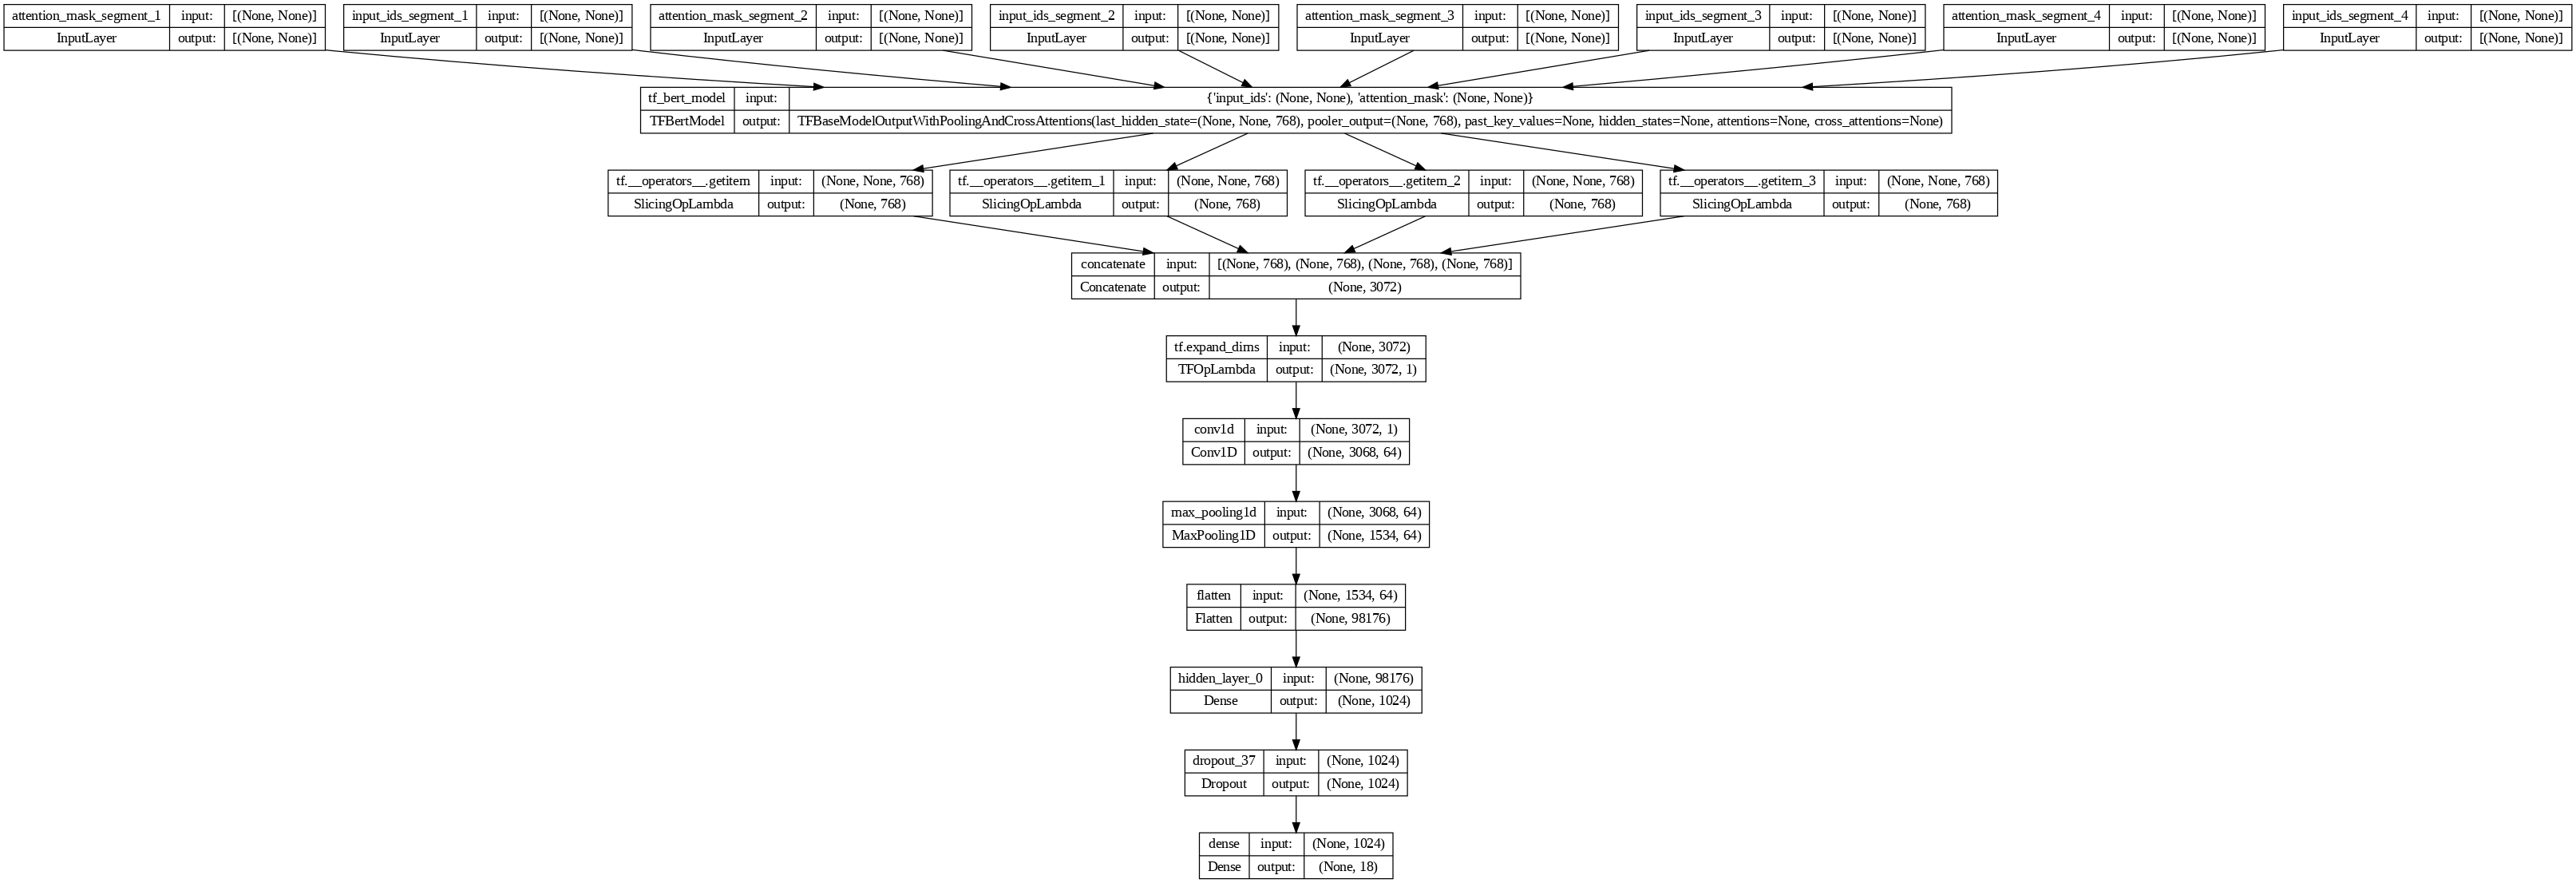

In [ ]:
keras.utils.plot_model(scibert_model, show_shapes=True, show_dtype=False, show_layer_names=True, dpi=90)

## Step 11: Convert the Data into a suitable format as required by the model and train the model for 2 epochs

The below function is designed to organize and prepare tokenized text data into a format suitable for training a deep learning model. It separates tokenized outputs into different segments (up to four), handling both input IDs and attention masks for each segment. This restructuring ensures that the input to the model is appropriately formatted, including handling cases where some documents have fewer segments by repeating the first segment's data. The function is used to format training, validation, and test datasets before they are fed into a SciBERT-CNN model for training.

In [ ]:
def restructure_encodings_for_training(tokenized_outputs):
    input_ids_segment_1, attention_masks_segment_1 = [], []
    input_ids_segment_2, attention_masks_segment_2 = [], []
    input_ids_segment_3, attention_masks_segment_3 = [], []
    input_ids_segment_4, attention_masks_segment_4 = [], []

    for doc_encodings in tokenized_outputs:
        segment_1 = doc_encodings[0]
        input_ids_segment_1.append(segment_1['input_ids'].numpy())
        attention_masks_segment_1.append(segment_1['attention_mask'].numpy())

        if len(doc_encodings) > 1:
            segment_2 = doc_encodings[1]
            input_ids_segment_2.append(segment_2['input_ids'].numpy())
            attention_masks_segment_2.append(segment_2['attention_mask'].numpy())
        else:
            input_ids_segment_2.append(segment_1['input_ids'].numpy())
            attention_masks_segment_2.append(segment_1['attention_mask'].numpy())

        if len(doc_encodings) > 2:
            segment_3 = doc_encodings[2]
            input_ids_segment_3.append(segment_3['input_ids'].numpy())
            attention_masks_segment_3.append(segment_3['attention_mask'].numpy())
        else:
            input_ids_segment_3.append(segment_1['input_ids'].numpy())
            attention_masks_segment_3.append(segment_1['attention_mask'].numpy())

        if len(doc_encodings) > 3:
            segment_4 = doc_encodings[3]
            input_ids_segment_4.append(segment_4['input_ids'].numpy())
            attention_masks_segment_4.append(segment_4['attention_mask'].numpy())
        else:
            input_ids_segment_4.append(segment_1['input_ids'].numpy())
            attention_masks_segment_4.append(segment_1['attention_mask'].numpy())

    input_ids_segment_1 = np.vstack(input_ids_segment_1)
    attention_masks_segment_1 = np.vstack(attention_masks_segment_1)
    input_ids_segment_2 = np.vstack(input_ids_segment_2)
    attention_masks_segment_2 = np.vstack(attention_masks_segment_2)
    input_ids_segment_3 = np.vstack(input_ids_segment_3)
    attention_masks_segment_3 = np.vstack(attention_masks_segment_3)
    input_ids_segment_4 = np.vstack(input_ids_segment_4)
    attention_masks_segment_4 = np.vstack(attention_masks_segment_4)

    return [input_ids_segment_1, attention_masks_segment_1, input_ids_segment_2, attention_masks_segment_2, input_ids_segment_3, attention_masks_segment_3, input_ids_segment_4, attention_masks_segment_4]

train_inputs = restructure_encodings_for_training(train_encodings)
valid_inputs = restructure_encodings_for_training(valid_encodings)
test_inputs = restructure_encodings_for_training(test_encodings)

model_history = scibert_model.fit(
    train_inputs,
    train_labels,
    validation_data=(valid_inputs, val_labels),
    batch_size=8,
    epochs=2,
    sample_weight=sample_weights
)


Epoch 1/2


4009/4009 [==============================] - 3588s 879ms/step - loss: 0.0143 - accuracy: 0.4962 - val_loss: 0.1481 - val_accuracy: 0.5121
Epoch 2/2
4009/4009 [==============================] - 3508s 875ms/step - loss: 0.0108 - accuracy: 0.5611 - val_loss: 0.1441 - val_accuracy: 0.5697


## Step 12: Evaluate and make predictions on the Validation set

Validation Data Set Evaluation

In [ ]:
val_score = scibert_model.evaluate(
    valid_inputs,
    val_labels,
    batch_size=8
)
print('Val loss:', val_score[0])
print('Val accuracy:', val_score[1])


502/502 [==============================] - 143s 285ms/step - loss: 0.1441 - accuracy: 0.5697
Val loss: 0.1440742462873459
Val accuracy: 0.5697181224822998


In [ ]:
val_predictions = scibert_model.predict(
    valid_inputs,
    batch_size=8
)


502/502 [==============================] - 154s 280ms/step


## Step 13: Plot the multilabel confusion matrix on the validation set

              precision    recall  f1-score   support

        AGRI       0.72      0.79      0.75       421
        BIOC       0.70      0.70      0.70       680
        CENG       0.41      0.71      0.52       185
        CHEM       0.52      0.68      0.59       225
        COMP       0.49      0.65      0.56       168
        EART       0.60      0.88      0.72       217
        ENER       0.63      0.76      0.69       246
        ENGI       0.51      0.77      0.61       425
        ENVI       0.65      0.63      0.64       517
        IMMU       0.72      0.60      0.66       273
        MATE       0.66      0.86      0.75       343
        MEDI       0.82      0.67      0.74       851
        MULT       0.95      0.60      0.74       377
        NEUR       0.85      0.87      0.86       357
        PHAR       0.49      0.82      0.62       229
        PHYS       0.51      0.77      0.61       228
        PSYC       0.50      0.84      0.63       144
        SOCI       0.84    

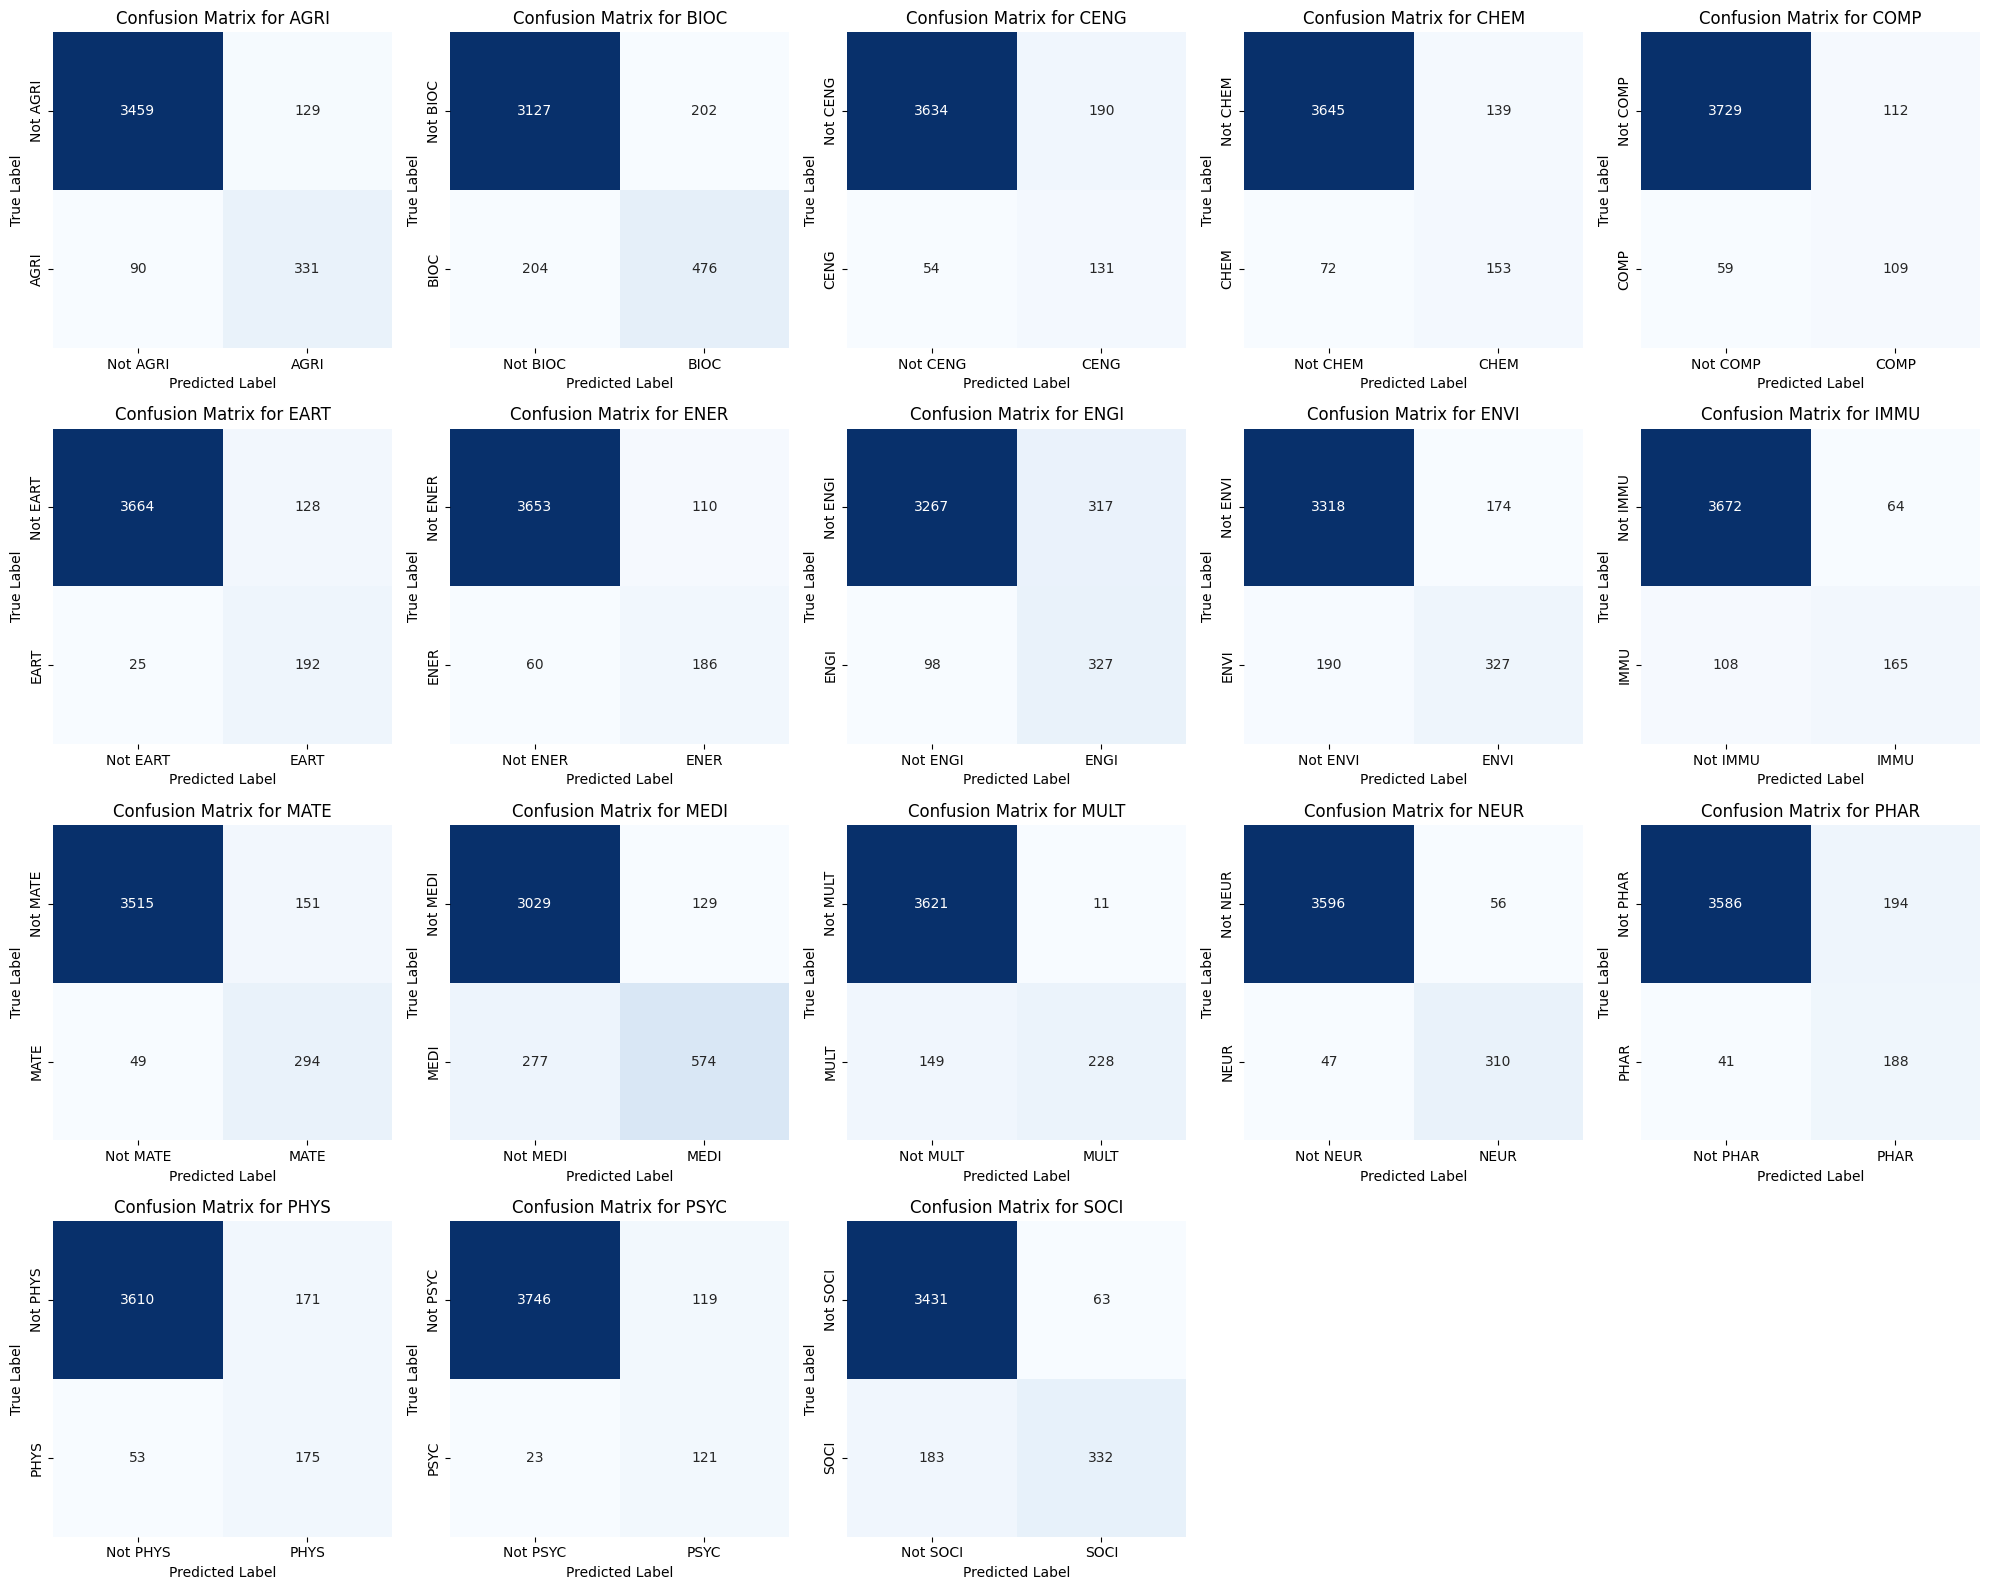

In [ ]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix

def show_results(model, features, true_labels, classes, threshold=0.5):
    yhat_val = (val_predictions >= threshold).astype(int)

    print(classification_report(true_labels, yhat_val, target_names=classes, zero_division=1))

    confusion_matrices = multilabel_confusion_matrix(true_labels, yhat_val)

    n_classes = len(classes)
    n_cols = 5
    n_rows = int(np.ceil(n_classes / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))

    axes = axes.flatten()

    for i, matrix in enumerate(confusion_matrices):
        sns.heatmap(matrix,
                    annot=True,
                    fmt='d',
                    cmap='Blues',
                    cbar=False,
                    ax=axes[i])
        axes[i].set_title(f'Confusion Matrix for {classes[i]}')
        axes[i].set_xlabel('Predicted Label')
        axes[i].set_ylabel('True Label')
        axes[i].set_xticklabels(['Not '+classes[i], classes[i]])
        axes[i].set_yticklabels(['Not '+classes[i], classes[i]], va='center')

    for ax in axes[n_classes:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

show_results(scibert_model,
             valid_inputs,
             val_labels,
             target_names)


## Step 14: Evaluate and make predictions on the test data set

In [ ]:
test_score = scibert_model.evaluate(
    test_inputs,
    test_labels,
    batch_size=8
)
print('Val loss:', test_score[0])
print('Val accuracy:', test_score[1])


501/501 [==============================] - 142s 283ms/step - loss: 0.1389 - accuracy: 0.5753
Val loss: 0.1388750672340393
Val accuracy: 0.5753493309020996


In [ ]:
test_predictions = scibert_model.predict(
    test_inputs,
    batch_size=8
)


501/501 [==============================] - 140s 280ms/step


## Step 15: Plot the multi label confusion matrix on the test set

              precision    recall  f1-score   support

        AGRI       0.71      0.78      0.74       413
        BIOC       0.69      0.69      0.69       653
        CENG       0.41      0.68      0.51       189
        CHEM       0.55      0.66      0.60       248
        COMP       0.47      0.57      0.51       157
        EART       0.57      0.93      0.71       217
        ENER       0.64      0.63      0.64       235
        ENGI       0.56      0.76      0.64       444
        ENVI       0.67      0.60      0.63       512
        IMMU       0.67      0.59      0.63       238
        MATE       0.70      0.89      0.78       331
        MEDI       0.82      0.71      0.76       851
        MULT       0.98      0.68      0.80       467
        NEUR       0.86      0.86      0.86       394
        PHAR       0.51      0.75      0.61       219
        PHYS       0.49      0.75      0.59       203
        PSYC       0.46      0.81      0.58       120
        SOCI       0.87    

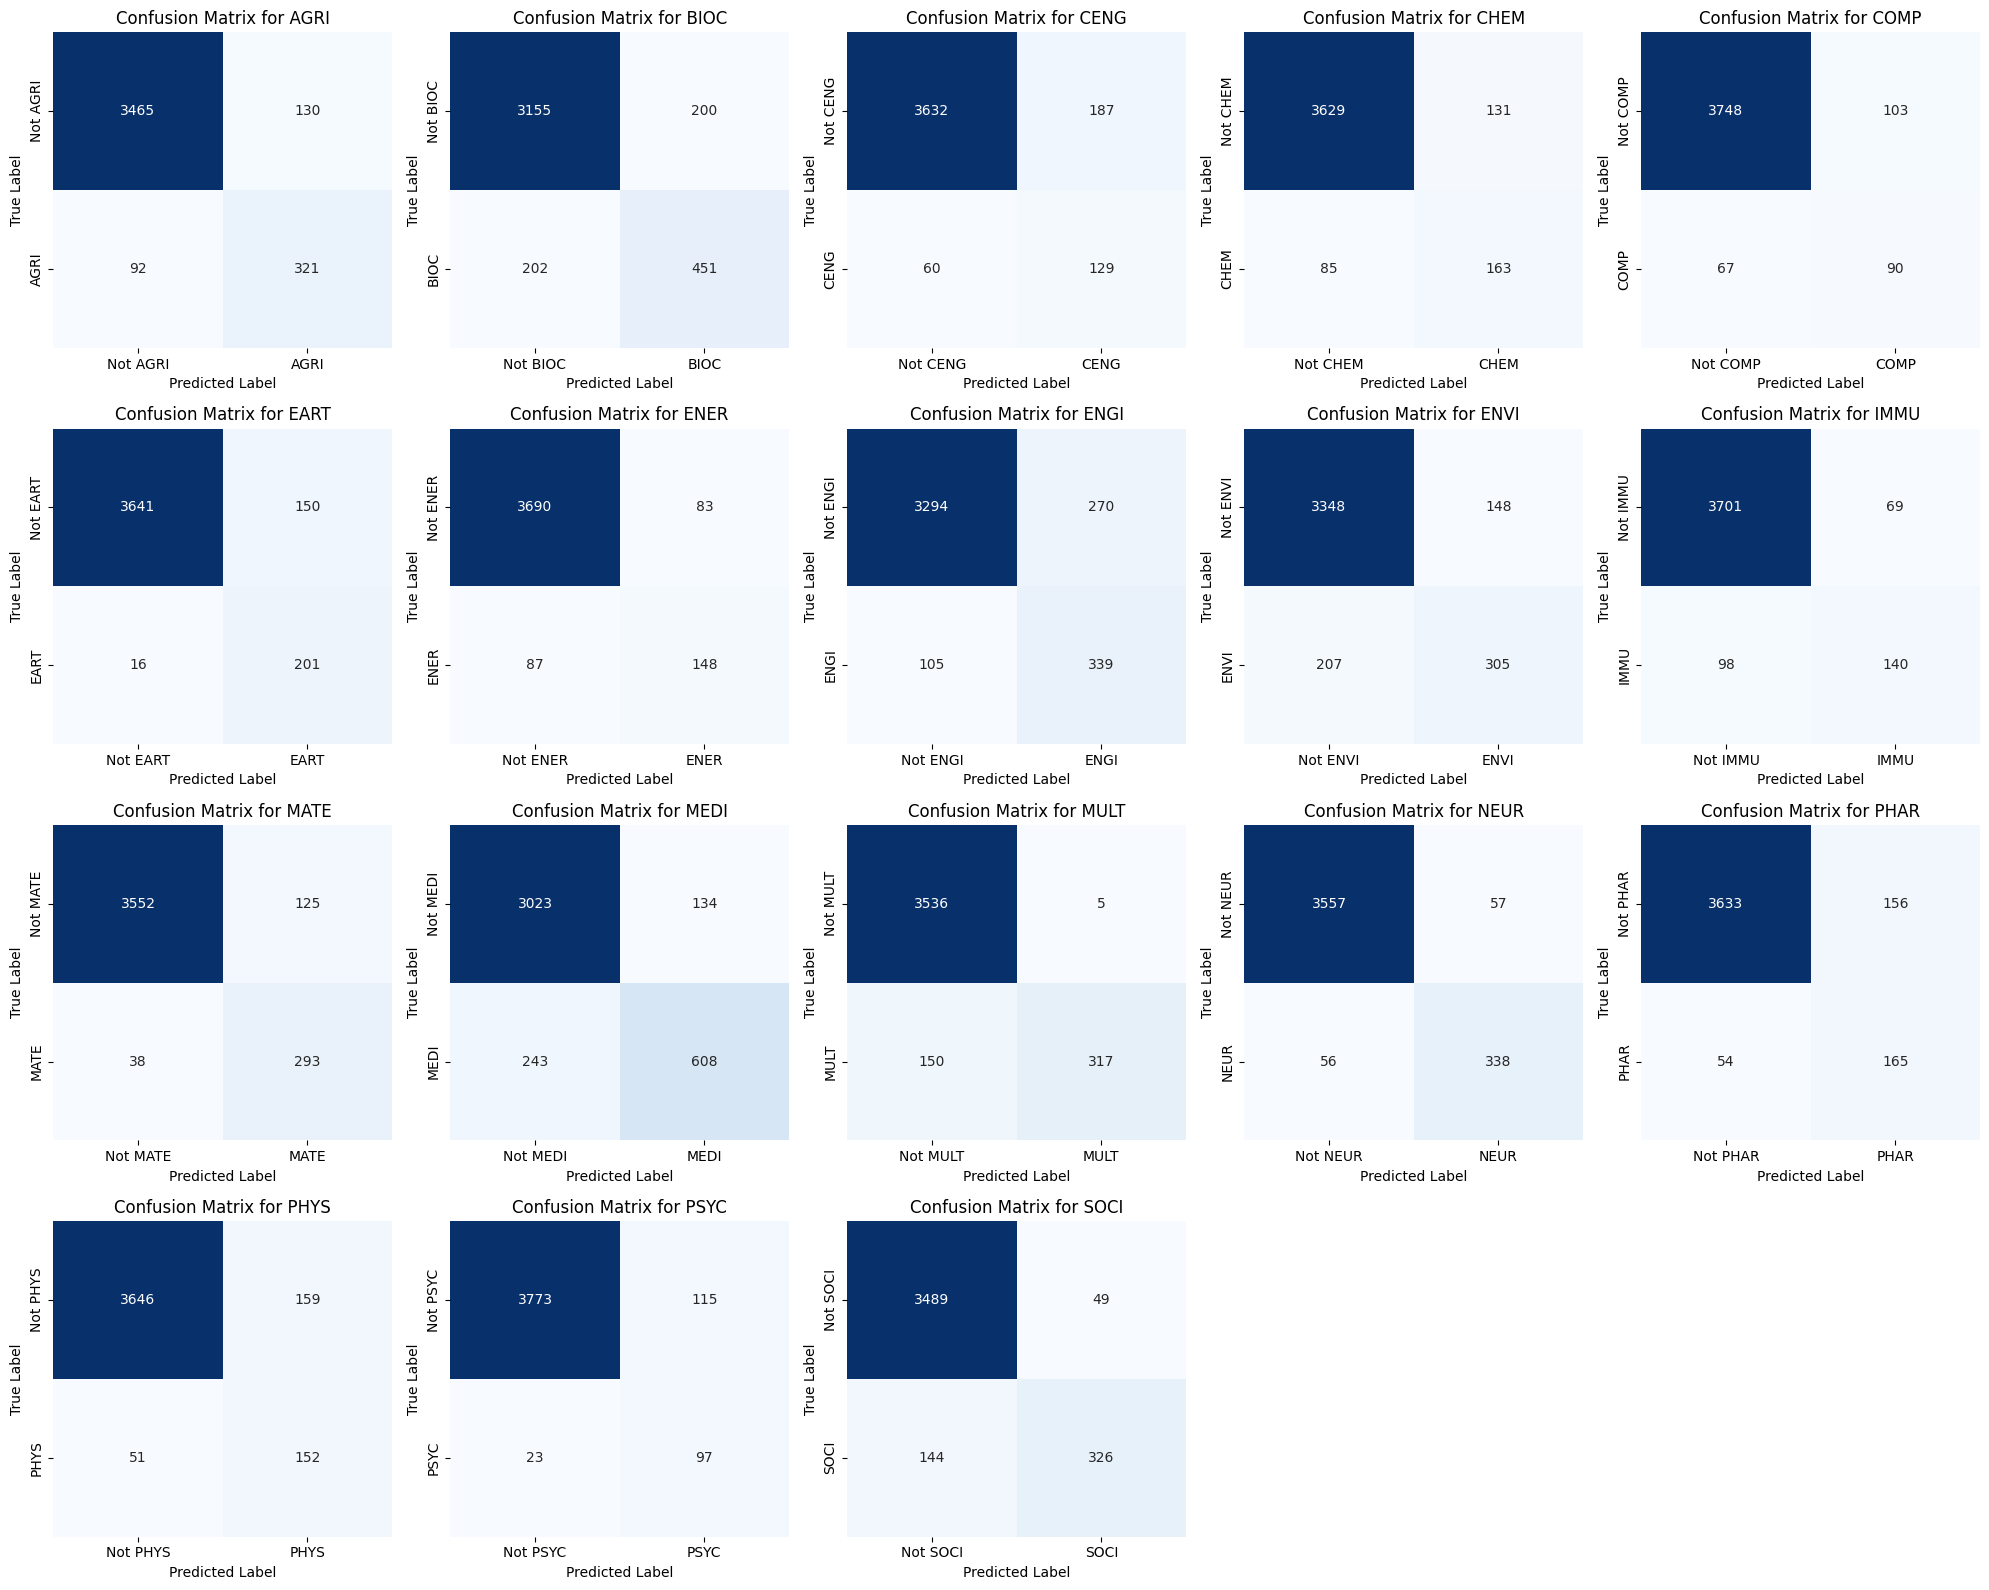

In [ ]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix

def show_results(model, features, true_labels, classes, threshold=0.5):
    yhat_test = (test_predictions >= threshold).astype(int)

    print(classification_report(true_labels, yhat_test, target_names=classes, zero_division=1))

    confusion_matrices = multilabel_confusion_matrix(true_labels, yhat_test)

    n_classes = len(classes)
    n_cols = 5
    n_rows = int(np.ceil(n_classes / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))

    axes = axes.flatten()

    for i, matrix in enumerate(confusion_matrices):
        sns.heatmap(matrix,
                    annot=True,
                    fmt='d',
                    cmap='Blues',
                    cbar=False,
                    ax=axes[i])
        axes[i].set_title(f'Confusion Matrix for {classes[i]}')
        axes[i].set_xlabel('Predicted Label')
        axes[i].set_ylabel('True Label')
        axes[i].set_xticklabels(['Not '+classes[i], classes[i]])
        axes[i].set_yticklabels(['Not '+classes[i], classes[i]], va='center')

    for ax in axes[n_classes:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

show_results(scibert_model,
             test_inputs,
             test_labels,
             target_names)


## Step 16: Plot the Receiving Operating characteristics for each label on the validation set

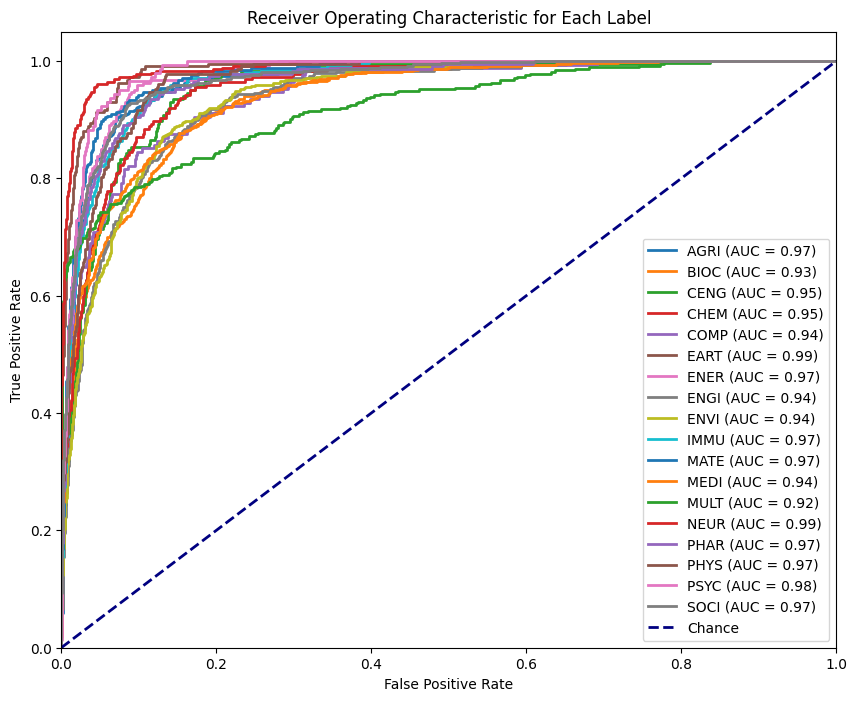

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_multilabel_roc(true_labels, predictions, target_names):
    """
    Function to plot the ROC curves for each label in multi-label classification.

    Parameters:
    - true_labels: Array-like of shape (n_samples, n_labels), ground truth label indicators.
    - predictions: Array-like of shape (n_samples, n_labels), prediction probabilities or decision function.
    - target_names: List of strings of shape (n_labels,), names of each of the labels.

    """
    n_labels = true_labels.shape[1]

    fig, ax = plt.subplots(figsize=(10, 8))

    for i in range(n_labels):
        fpr, tpr, _ = roc_curve(true_labels[:, i], predictions[:, i])
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, lw=2, label=f'{target_names[i]} (AUC = {roc_auc:.2f})')

    # Plot chance line
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance')

    # Customize the plot
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic for Each Label')
    ax.legend(loc="lower right")

    # Show the plot
    plt.show()

plot_multilabel_roc(val_labels, val_predictions, target_names)


## Step 17: Plot the Receiving Operating characteristics for each label on the test set

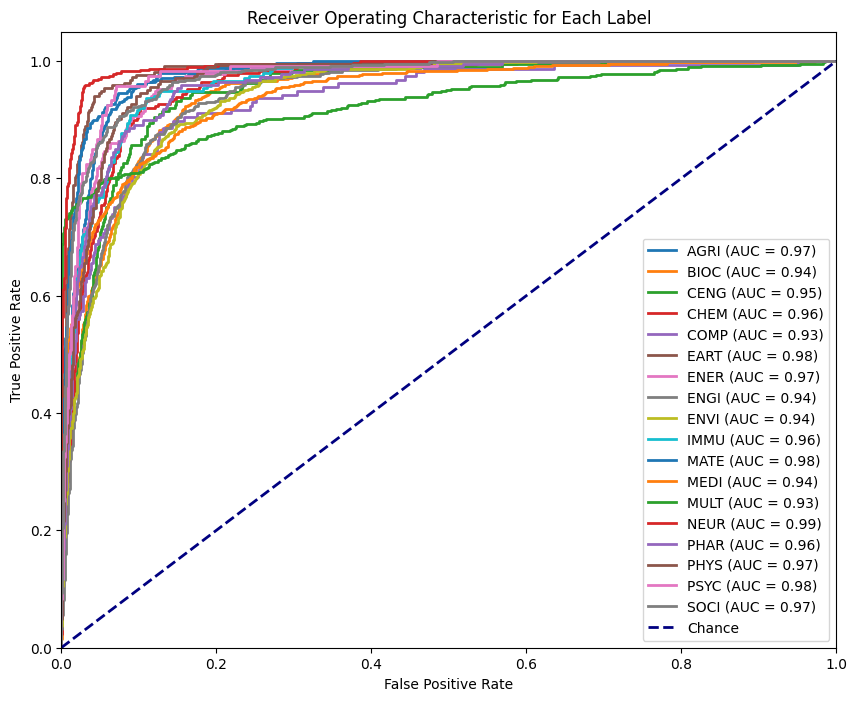

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_multilabel_roc(true_labels, predictions, target_names):
    """
    Function to plot the ROC curves for each label in multi-label classification.

    Parameters:
    - true_labels: Array-like of shape (n_samples, n_labels), ground truth label indicators.
    - predictions: Array-like of shape (n_samples, n_labels), prediction probabilities or decision function.
    - target_names: List of strings of shape (n_labels,), names of each of the labels.

    """
    n_labels = true_labels.shape[1]

    fig, ax = plt.subplots(figsize=(10, 8))

    for i in range(n_labels):
        fpr, tpr, _ = roc_curve(true_labels[:, i], predictions[:, i])
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, lw=2, label=f'{target_names[i]} (AUC = {roc_auc:.2f})')

    # Plot chance line
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance')

    # Customize the plot
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic for Each Label')
    ax.legend(loc="lower right")

    # Show the plot
    plt.show()

plot_multilabel_roc(test_labels, test_predictions, target_names)


## Step 17: Stores the predictions in a csv file for performing a detailed Error Analysis

In [ ]:
!pip install google-auth

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

def save_predictions_to_csv(test_predictions, test_texts, test_df, target_names, result_path, threshold=0.5):
    """
    Process model predictions and save a CSV file with abstracts, true labels, predicted labels,
    the most probable predicted label, and its probability.

    Args:
        test_predictions (np.array): The predictions from the model, assumed to be probabilities.
        test_texts (list or np.array): The texts that were input to the model for prediction.
        test_df (pd.DataFrame): The original DataFrame containing the true labels.
        target_names (list): List of target class names corresponding to indices in model outputs.
        result_path (str, optional): Path to save the resulting CSV file. Defaults to './'.
        threshold (float, optional): Probability threshold to consider a prediction as positive. Defaults to 0.5.
    """
    predicted_labels = []
    max_probs = []
    max_labels = []

    for probs in test_predictions:
        labels = [target_names[idx] for idx, p in enumerate(probs) if p >= threshold]
        predicted_labels.append(labels)

        # Identify the max probability and corresponding label
        max_idx = np.argmax(probs)
        max_prob = probs[max_idx]
        max_label = target_names[max_idx]

        max_probs.append(max_prob)
        if labels:
            max_labels.append(max_label)
        else:
            max_probs[-1] = 0  # Reset max_prob if no labels meet the threshold
            max_labels.append("No Label")

    # Preparing the DataFrame
    result_df = pd.DataFrame({
        'abstract': test_texts,
        'true_label': test_df['subjareas'],
        'pred_label': predicted_labels,
        'max_pred_label': max_labels,
        'max_prediction_probability': max_probs
    })

    result_df['pred_label'] = result_df['pred_label'].apply(lambda x: ', '.join(x) if x else 'No Label')

    # Saving the results
    result_df.to_csv(result_path + 'scibert_cnn_part6.csv', index=False)

    return result_df

result_path = '/content/drive/MyDrive/'
save_predictions_to_csv(test_predictions, concatenated_test_texts, test_df, target_names, result_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,abstract,true_label,pred_label,max_pred_label,max_prediction_probability
0,[In the last years eggplant has received a gre...,[AGRI],AGRI,AGRI,0.969342
1,[Nitazoxanide is a thiazolide compound that wa...,"[IMMU, PHAR]",PHAR,PHAR,0.957676
2,[Aims: To use a mouse model of imiquimod-induc...,[MULT],PHAR,PHAR,0.747345
3,[This paper presents an inter-comparison of th...,"[EART, ENVI]","EART, ENVI",ENVI,0.978855
4,[Compared with conventional household one/two ...,"[COMP, ENGI, SOCI]","ENGI, SOCI",SOCI,0.983800
...,...,...,...,...,...
4003,[Osteopontin (OPN) is a multifunctional protei...,"[AGRI, IMMU]","AGRI, CHEM",AGRI,0.993948
4004,[The Witwatersrand Basin Goldfields (WBG) have...,[AGRI],"AGRI, EART, ENVI",AGRI,0.819383
4005,[The concept of social licence to operate (SLO...,"[ENER, SOCI]","ENER, SOCI",ENER,0.859961
4006,[Hydrogen sulfide (H 2 S) gas sensors in the f...,[MATE],"ENGI, MATE, PHYS",MATE,0.806063
